# Stance detection with a Split-loss Classifier
In this notebook, the task of stance detection is tackled using BERT to encode the examples of a stance detection datasets and using that representation for classification; the objective is revised to be twofold, accounting for presence and direction fo stance rather than for three independent labels.

## Setup
Importing necessary modules and functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

In [3]:
torch.cuda.set_device(0)

In [4]:
from datasets import SemEval
from torch import nn, optim
from bert import encode
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import f1_score, classification_report
from math import ceil
from warnings import filterwarnings
from utils import plot_confusion_matrix, print_misclassifications, get_batch, save_state_dict

In [5]:
filterwarnings("ignore")

## Model definition
The following cells define the blueprint of the model employed for this task; a function to instantiate the model is also provided, ensuring that each time the same initialisation is performed to guarantee reproducibility.

In [6]:
class Model(nn.Module):
    
    def __init__(self, input_size, intermediate_size, target_size):
        super().__init__()
        self.classifier_1 = nn.Sequential(nn.Linear(input_size, intermediate_size), nn.ReLU())
        self.classifier_2_1 = nn.Sequential(nn.Linear(intermediate_size, target_size), nn.Softmax(dim=1))
        self.classifier_2_2 = nn.Sequential(nn.Linear(intermediate_size, target_size), nn.Softmax(dim=1))
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, inputs, labels=None, alpha=0.5):
        intermediate_representation = self.classifier_1(inputs)
        presence_probabilities  = self.classifier_2_1(intermediate_representation)
        direction_probabilities = self.classifier_2_2(intermediate_representation)
        
        loss = None
        if labels is not None:
            loss = alpha * self.cross_entropy(presence_probabilities, (labels != 0).long())
            loss = loss + (1. - alpha) * self.cross_entropy(direction_probabilities[labels != 0], labels[labels != 0] - 1)
            
        probabilities = torch.zeros(inputs.shape[0], 3)
        probabilities[:,0] = presence_probabilities[:,0]
        probabilities[:,1] = presence_probabilities[:,1] * direction_probabilities[:,0]
        probabilities[:,2] = presence_probabilities[:,1] * direction_probabilities[:,1]
            
        return probabilities, torch.argmax(probabilities, 1), loss

In [7]:
def get_model(state_dict=None):
    torch.manual_seed(42)
    model = Model(768, 64, 2).cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

## Loading and Encoding
In the following, the stance dataset is loaded and its texts and targets are encoded to form the inputs for the model.

In [8]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [9]:
training_inputs = encode(training.texts, training.targets, method="conditional-target", maximum_length=80).cuda(), torch.tensor(training.stances).cuda()
testing_inputs  = encode(testing.texts,  testing.targets,  method="conditional-target", maximum_length=80).cuda(), torch.tensor(testing.stances ).cuda()

## Training
The training environment is set up.

In [10]:
model = get_model()
batch_size = 48
optimiser = optim.Adam(model.parameters(), lr=3e-4)
step, steps_since, early_stopping = 0, 0, 5000

In [11]:
schedule = lambda step: max(0.5, step / 1000.)

In [12]:
optimal_score, optimal_model_state_dict = 0., None

In [13]:
training_loss, testing_loss = [], []

In [ ]:
while steps_since < early_stopping:

    model.zero_grad()
    optimiser.zero_grad()
    model.train()
    
    #alpha = schedule(step)
    alpha = 0.5

    inputs = get_batch(step, batch_size, training_inputs)
    _, _, loss = model(*inputs, alpha)
    training_loss.append(float(loss))
    loss.backward()
    optimiser.step()

    model.eval()

    _, predictions, loss = model(*testing_inputs, alpha)
    testing_loss.append(float(loss))
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    score = np.mean(scores)
    
    if score > optimal_score:
        optimal_score = score
        print("{}\t{}\t{}\t{}".format(step, *scores, score))
        optimal_model_state_dict = deepcopy(model.state_dict())
        steps_since = 0
    else:
        steps_since += 1

    step += 1

In [15]:
save_state_dict(optimal_model_state_dict, "bert_split_classifier")

## Evaluation
The training and testing loss is plotted; the optimal testing model is loaded and the evaluation metrics are computed; misclassifcations are printed.

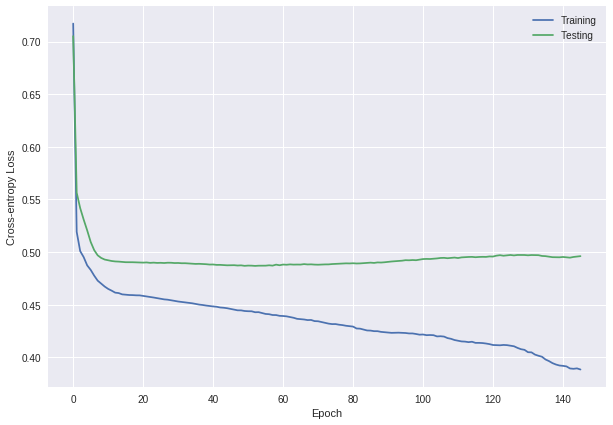

In [16]:
plt.style.use("seaborn")
plt.figure(figsize=(10, 7))
plt.plot(training_loss[::ceil(len(training) / batch_size)])
plt.plot(testing_loss[::ceil(len(training) / batch_size)])
plt.legend(["Training", "Testing"])
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
pass

In [17]:
model = get_model(state_dict=optimal_model_state_dict)
model.eval()

Model(
  (classifier_1): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
  )
  (classifier_2_1): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Softmax()
  )
  (classifier_2_2): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Softmax()
  )
  (cross_entropy): CrossEntropyLoss()
)

In [18]:
_, predictions, _ = model(*testing_inputs)

In [19]:
print(classification_report(testing.stances, predictions.cpu()))
print(np.mean(f1_score(testing.stances, predictions.cpu(), average=None)[1:]))
print(np.mean(f1_score(testing.stances, predictions.cpu(), average=None)[:]))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53       230
           1       0.59      0.67      0.63       304
           2       0.75      0.74      0.75       715

    accuracy                           0.68      1249
   macro avg       0.64      0.64      0.63      1249
weighted avg       0.68      0.68      0.68      1249

0.6879219927535443
0.6349487685642344


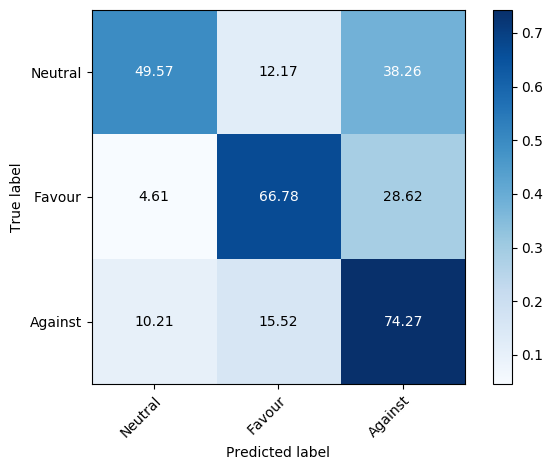

In [20]:
plot_confusion_matrix(testing.stances, predictions.cpu())

In [33]:
print_misclassifications(testing, predictions.cpu())

Text:		@Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST
Target:		Atheism
Stance:		Against
Prediction:	Favour

Text:		#God is utterly powerless without Human intervention... #SemST
Target:		Atheism
Stance:		Against
Prediction:	Favour

Text:		This world needs a tight group hug. Tight enough to relieve them from all this anger and hate. #MakePeaceWithEachOther #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		Morality is not derived from religion, it precedes it. -Christopher 'The Hitch' Hitchens #freethinkers #SemST
Target:		Atheism
Stance:		Against
Prediction:	Favour

Text:		@SecularDutchess I'll be your huckleberry @DeanModified #SemST
Target:		Atheism
Stance:		Against
Prediction:	Neutral

Text:		#BIBLE = Big Irrelevant Book of Lies and Exaggerations ~ #Judaism #God #TeamJesus #Islam ~ #Truth & #Freedom = #SemST
Target:		Atheism
Stance:		Against
Prediction:	Favour

Text:		If only dre